In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report, roc_curve

from xgboost import XGBClassifier
from xgboost import DMatrix, cv
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import seaborn as sns
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import pandas as pd
import pickle
import joblib
%matplotlib inline
# import

In [2]:
raw_data_folder = "raw_data//"
processed_data_folder = "processed_data//"
models_folder = "models//"

# 1.Preprocessing Data

In [3]:
raw_train = pd.read_csv(raw_data_folder +'train.csv')
raw_test = pd.read_csv(raw_data_folder + 'test.csv')
raw_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
raw_train.info()
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

## 1.1 Imputing
&ensp; Fortunately, we have only 2 columns that have missing values with significant frequency, those being Cabin(cabin number)  and Age.
Fare and Embarked also have missing values but they are few, the train set only missing 2 Embarked values and full Fare information, and the test set missing only 1 Fare value.
With Embarked, the situation is simple because the main majority of people that got on, did so at Southampton and there are only 2 missing values, so just attributing "S" to them should be sufficient.

The problem is that "Cabin" has only around 1/4 of the values not missing, even though it could have been an useful piece of information. It would be better to just drop it because the number of values we actually have is very small.

For Age, since it is a numerical column, numerous approaches may be adopted and each may have its advantages(median, mean or inferring it from other columns). Because mean fits quite nicely with the age distribution (as we see below, the red line being the mean), we will use it.

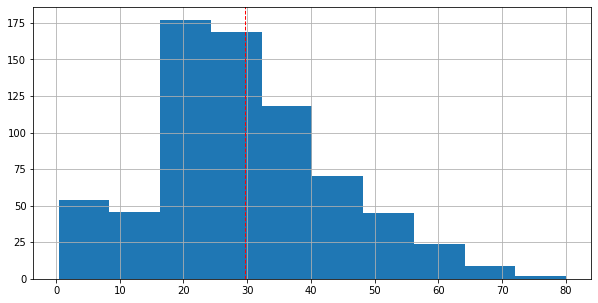

In [5]:
fig, ax = plt.subplots(figsize = (10,5))
raw_train.Age.hist(ax =ax , label = "train")
ax.axvline(x=raw_train.Age.mean(),ymin= 0, ymax = 180, color='r', linestyle='dashed', linewidth=1)

In [6]:
print("Train: ",raw_train.Cabin.isna().sum(), "missing out of ", len(raw_train), "(%f)percent"%(raw_train.Cabin.isna().sum() / len(raw_train) * 100)) 
print("Test: ",raw_test.Cabin.isna().sum(), "missing out of ", len(raw_test), "(%f)percent"%(raw_test.Cabin.isna().sum() / len(raw_test) * 100))


Train:  687 missing out of  891 (77.104377)percent
Test:  327 missing out of  418 (78.229665)percent


In [7]:
print(raw_train.Embarked.isna().sum())
raw_train.groupby("Embarked").count()

2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
Embarked,,,,,,,,,,,
C,168,168,168,168,168,130,168,168,168,168,69
Q,77,77,77,77,77,28,77,77,77,77,4
S,644,644,644,644,644,554,644,644,644,644,129


In [8]:
def imputing(raw_train, method='mean', age_value = None):
    train = raw_train.copy()
    train.Embarked.fillna("S",inplace = True)
    train.Fare.fillna(train.Fare.mean(),inplace = True)
    
    train.drop("Cabin", axis = 1, inplace = True)
    
    if method == 'mean':
        train.Age.fillna(train.Age.mean(), inplace = True)
    if method == 'median':
        train.Age.fillna(train.Age.median(), inplace = True)
    if age_value is not None:
        train.Age.fillna(age_value, inplace = True)
    
    train['Alone'] = 0 + (train.SibSp + train.Parch > 0)
    return train

In [9]:
imputed_train = imputing(raw_train)
imputed_test = imputing(raw_test, age_value = raw_train.Age.mean())

Check the inputing was done correctly

In [10]:
imputed_train.info()
imputed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Alone        891 non-null    int32  
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 80.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1 

In [11]:
def split_train(dataset,ratio = 0.2):
    train_data = dataset.copy()
    train_y = train_data.Survived
    train_data.drop("Survived",axis = 1,inplace = True)
    if ratio != 0:
        return model_selection.train_test_split(train_data,train_y,test_size=ratio)
    else:
        return train_data,[],train_y,[]

In [12]:
X_train, X_test, y_train, y_test = split_train(imputed_train) # example of use

In [13]:
ordinal = OrdinalEncoder()
onehot = OneHotEncoder()

## 1.2 Transforming:

#### Important note:
    While i tried using the Transformers provided in sklearn, they reordered the columns in a way that made the dataset unmanageable afterwards, and some later visualisations and deductions rely on the fact that we know which are the columns. 
    This is by far the biggest inconvenience until now, but the amount of work needed to work around it is far greater than the work needed to develop a solution in pandas for both encodings used. 
<br>
Here we drop the columns which are not useful in making predictions as they offer no real information(Ticked ID and Passenger ID) as to they may provide the boosted trees an opportunity to overfit and transform the categorical ones (Sex and Embarked) into their encodings. Also, we exctract knowledge from the Name column in the form of Title, which may provide additional infomation in regard to the social status of the person.

In [14]:
def name_to_title(name):
    return name.split(',')[1].split('.')[0].strip()
titles_train = set([name_to_title(name) for name in raw_train['Name']])
titles_test = set([name_to_title(name) for name in raw_test['Name']])
titles = titles_train | titles_test # set union
titles

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

We create a dictionary for standardinze different terms to a common meaning (eg. Captain and Colonel to Officer)

In [15]:
title_dict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona":"Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}
def transform_titles(dataset):
    dataset['Title'] = dataset['Name'].map(lambda name:name_to_title(name))
    dataset['Title'] = dataset['Title'].map(lambda title:title_dict[title])
transform_titles(imputed_test)
imputed_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Alone,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,1,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,1,Mrs


In [16]:
def transform(dataset, encoder):
    transformed_dataset = dataset.copy()
    transformed_dataset['Title'] = transformed_dataset['Name'].map(lambda name:name_to_title(name))
    transformed_dataset['Title'] = transformed_dataset['Title'].map(lambda title:title_dict[title])
    transformed_dataset.drop("Name",axis =1, inplace = True)
    transformed_dataset.drop("PassengerId", axis =1, inplace = True)
    transformed_dataset.drop("Ticket",axis =1, inplace = True)
    if type(encoder) is OrdinalEncoder:
        transformed_dataset.Sex = encoder.fit_transform(transformed_dataset.Sex.values.reshape(-1,1))
        transformed_dataset.Embarked = encoder.fit_transform(transformed_dataset.Embarked.values.reshape(-1,1))
        transformed_dataset.Title = encoder.fit_transform(transformed_dataset.Title.values.reshape(-1,1))
    if type(encoder) is OneHotEncoder:
        sex_dummies = pd.get_dummies(transformed_dataset['Sex'], prefix = 'Sex')
        embarked_dummies = pd.get_dummies(transformed_dataset['Embarked'], prefix = 'Embarked')
        title_dummies = pd.get_dummies(transformed_dataset['Title'], prefix = 'Title')
        transformed_dataset = pd.concat([transformed_dataset,embarked_dummies,sex_dummies,title_dummies], axis = 1)
        transformed_dataset.drop("Sex",axis = 1, inplace = True)
        transformed_dataset.drop("Embarked", axis = 1, inplace =  True)
        transformed_dataset.drop("Title",axis =1, inplace = True)
    return transformed_dataset

In [17]:
transformed_train_onehot = transform(X_train,onehot)
transformed_test_onehot = transform(X_test,onehot)

In [18]:
transformed_train_onehot.head()

,Pclass,Age,SibSp,Parch,Fare,Alone,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
521,3,22.0,0,0,7.8958,0,0,0,1,0,1,0,0,1,0,0,0
523,1,44.0,0,1,57.9792,1,1,0,0,1,0,0,0,0,1,0,0
532,3,17.0,1,1,7.2292,1,1,0,0,0,1,0,0,1,0,0,0
27,1,19.0,3,2,263.0000,1,0,0,1,0,1,0,0,1,0,0,0
61,1,38.0,0,0,80.0000,0,0,0,1,1,0,0,1,0,0,0,0


In [19]:
transformed_train_ordinal = transform(X_train,ordinal)
transformed_test_ordinal = transform(X_test,ordinal)
transformed_train_ordinal.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Alone,Title
521,3,1.0,22.0,0,0,7.8958,2.0,0,2.0
523,1,0.0,44.0,0,1,57.9792,0.0,1,3.0
532,3,1.0,17.0,1,1,7.2292,0.0,1,2.0
27,1,1.0,19.0,3,2,263.0000,2.0,1,2.0
61,1,0.0,38.0,0,0,80.0000,2.0,0,1.0


## 1.3 Standardizing
Many algorithms benefit from having mean 0 and variance 1, especially for continuous variables.
<br>
Since we use PCA, this method is preferred to others such as min/max normalization
<br>
Also, the test set should be normalized by the train set's mean and std.

In [20]:
def standardize(dataset, means = None , stds = None ,columns = ["Age","Fare"]):
    """If means is null, it will standardize using the dataframe's values.
    If the means is given, it will use these and the std's provided."""
    standardized_dataset = dataset.copy()
    for i,column_name in enumerate(columns):
        column = standardized_dataset[column_name]
        if means is None:
            mean = column.mean()
            std = column.std()
        else:
            mean = means[i]
            std = stds[i]
        standardized_dataset[column_name] = (column - mean) / std
    return standardized_dataset

In [21]:
means = [transformed_train_ordinal.Age.mean(),transformed_train_ordinal.Fare.mean()]
stds = [transformed_train_ordinal.Age.std(), transformed_train_ordinal.Fare.std()]
standardized_train_ordinal = standardize(transformed_train_ordinal)
standardized_test_ordinal =  standardize(transformed_test_ordinal, means,stds)


Double checking that the standardization was done correctly:
The test mean is not 0 due to the train-test mismatch

In [22]:
standardized_test_ordinal.Age.mean()

0.09261075635116654

In [23]:
standardized_train_ordinal.Age.mean()

7.172789204038933e-17

## 1.4 Save all the preprocessing steps

In [24]:
raw_train = pd.read_csv(raw_data_folder+'train.csv')
raw_test = pd.read_csv(raw_data_folder+'test.csv')

imputed_train = imputing(raw_train)
imputed_test = imputing(raw_test, age_value = raw_train.Age.mean())


imputed_train.to_csv(processed_data_folder+"imputed_train.csv",index = False)
imputed_test.to_csv(processed_data_folder +"imputed_test.csv",index = False)

In [25]:
ordinal = OrdinalEncoder()
onehot = OneHotEncoder()

ordinal_train = transform(imputed_train,ordinal)
onehot_train = transform(imputed_train,onehot)

ordinal_test = transform(imputed_test,ordinal)
onehot_test = transform(imputed_test,onehot)


ordinal_train.to_csv(processed_data_folder + "transformed_train_ordinal.csv",index = False)
onehot_train.to_csv(processed_data_folder + "transformed_train_onehot.csv",index = False)

ordinal_train.to_csv(processed_data_folder + "transformed_test_ordinal.csv",index = False)
onehot_test.to_csv(processed_data_folder + "transformed_test_onehot.csv",index = False)

In [26]:
means = [ordinal_train.Age.mean(),ordinal_train.Fare.mean()]
stds = [ordinal_train.Age.std(), ordinal_train.Fare.std()]
standardized_train_ordinal = standardize(ordinal_train)
standardized_test_ordinal=  standardize(ordinal_test, means,stds)

standardized_train_ordinal.to_csv(processed_data_folder + "standardized_train_ordinal.csv",index = False)
standardized_test_ordinal.to_csv(processed_data_folder + "standardized_test_ordinal.csv",index = False)


means = [onehot_train.Age.mean(),onehot_train.Fare.mean()]
stds = [onehot_train.Age.std(), onehot_train.Fare.std()]
standardized_train_onehot = standardize(onehot_train)
standardized_test_onehot=  standardize(onehot_test, means,stds)

standardized_train_onehot.to_csv(processed_data_folder + "standardized_train_onehot.csv",index = False)
standardized_test_onehot.to_csv(processed_data_folder + "standardized_test_onehot.csv",index = False)

# 2. Visualisation

In [27]:
train_data = pd.read_csv(processed_data_folder + 'imputed_train.csv')
test_data = pd.read_csv(processed_data_folder + 'imputed_test.csv')


We recheck if we imputed all of the values needed.

In [28]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Alone        891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

For data with low cardinality, we will use pie charts. Numerical columns, even some of the ones with low cardinality, are better visualised using methods such as histograms.

In [29]:
types = train_data.dtypes
pd.DataFrame([train_data.apply(pd.Series.nunique),types])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Alone
0,891,2,3,891,2,89,7,7,681,248,3,2
1,int64,int64,int64,object,object,float64,int64,int64,object,float64,object,int64


First we will look at the distribution of surivivors.

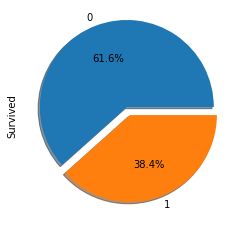

In [30]:
ax = plt.subplot()
explode = [0.1,0]
train_data.Survived.value_counts().plot(kind = 'pie', ax = ax, autopct='%1.1f%%', shadow = True, explode = explode)


## 2.1 Test - train discrepancy
We should compare the distrution in the test set and the train set to see if the data distributions vary too greatly for some variables. If that is the case, some methods to correct this issue might be needed.

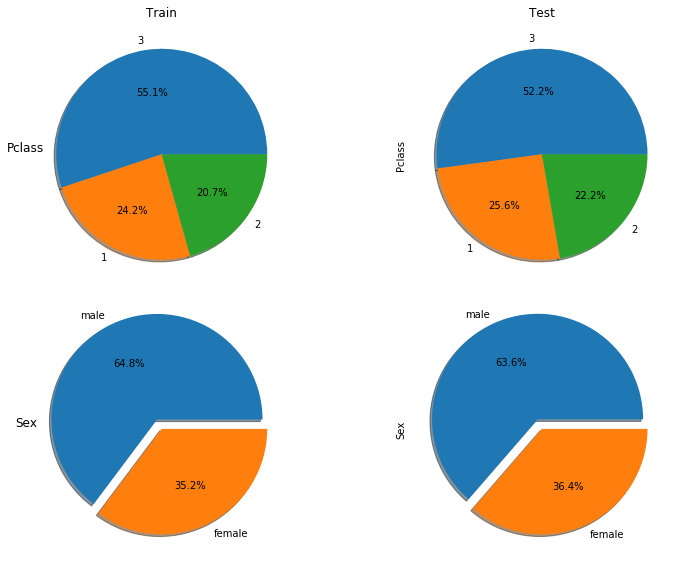

In [31]:

cols = ['{}'.format(col) for col in ['Train',"Test"]]
rows = ['{}'.format(row) for row in ['Pclass', 'Sex']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


train_data.Pclass.value_counts().plot(kind = 'pie', ax = axes[0][0], autopct='%1.1f%%', shadow = True, title = "Train")
test_data.Pclass.value_counts().plot(kind = 'pie', ax = axes[0][1], autopct='%1.1f%%', shadow = True, title = "Test")
train_data.Sex.value_counts().plot(kind = 'pie', ax = axes[1][0], autopct='%1.1f%%', shadow = True, explode = explode)
test_data.Sex.value_counts().plot(kind = 'pie', ax = axes[1][1], autopct='%1.1f%%', shadow = True, explode = explode)


for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
fig.tight_layout()
plt.show()

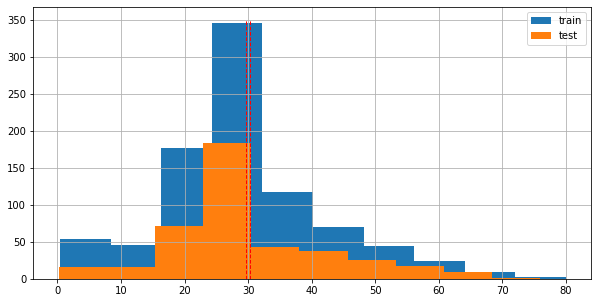

In [32]:
fig, ax = plt.subplots(figsize = (10,5))
train_data.Age.hist(ax =ax , label = "train")
test_data.Age.hist(ax = ax, label = "test")
ax.legend(loc = "upper right")
ax.vlines(x=[train_data.Age.mean(), test_data.Age.mean()],ymin= 0, ymax = 350, color='r', linestyle='dashed', linewidth=1)

#### Conclusion:
We can see that the distributions match well enough, so no measure to adjust the training set or oversample is required.
<br>
Now, we can move on to :
## 2.2 Visualising feature importance and correlation

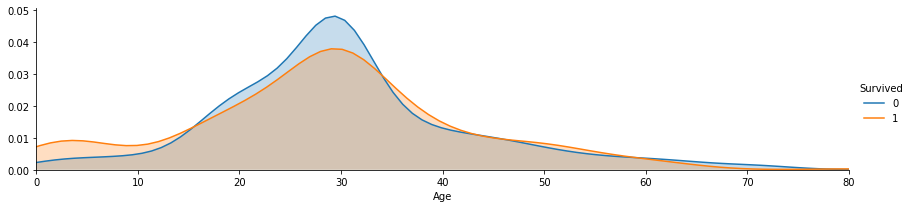

In [33]:
a = sns.FacetGrid( train_data, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train_data['Age'].max()))
a.add_legend()

To better visualize the distribution of survivors in respect to some features, we add a "died" column, used just for visualisation as to not introduce too much correlation between variables

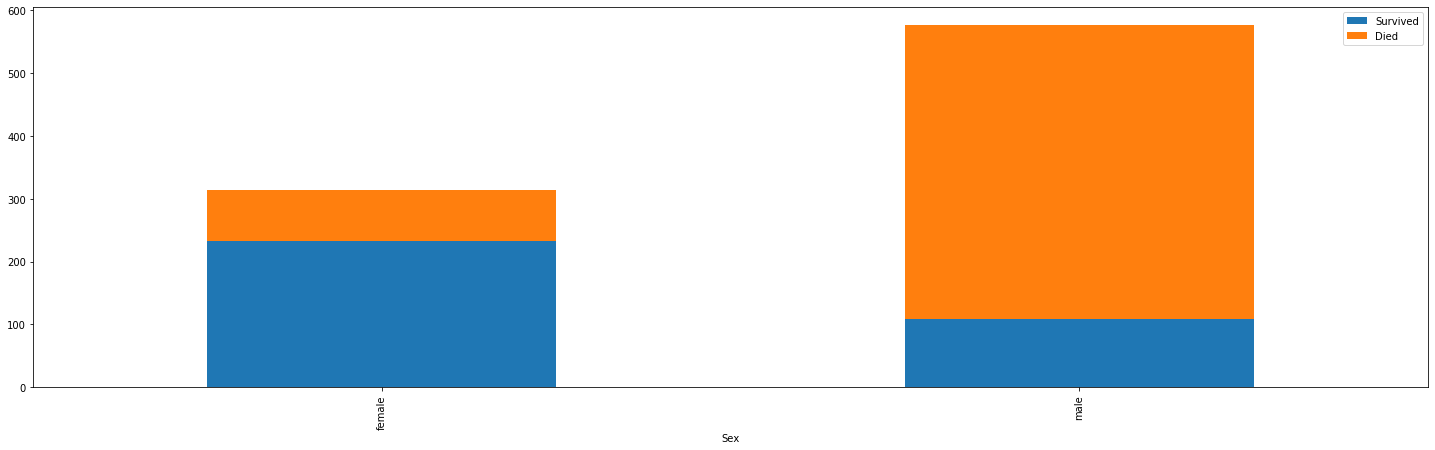

In [34]:
train_data["Died"] = 1 - train_data.Survived
train_data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

In [35]:
transformed = pd.read_csv(processed_data_folder + "transformed_train_ordinal.csv")
transformed

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Alone,Title
0,0,3,1.0,22.000000,1,0,7.2500,2.0,1,2.0
1,1,1,0.0,38.000000,1,0,71.2833,0.0,1,3.0
2,1,3,0.0,26.000000,0,0,7.9250,2.0,0,1.0
3,1,1,0.0,35.000000,1,0,53.1000,2.0,1,3.0
4,0,3,1.0,35.000000,0,0,8.0500,2.0,0,2.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1.0,27.000000,0,0,13.0000,2.0,0,4.0
887,1,1,0.0,19.000000,0,0,30.0000,2.0,0,1.0
888,0,3,0.0,29.699118,1,2,23.4500,2.0,1,1.0
889,1,1,1.0,26.000000,0,0,30.0000,0.0,0,2.0


<br>
<br>
We will now analyze the correlations in the dataset, taking into account the transformed variables
<br>
Note that we introduced a highly correlated value when adding the "Alone" columns, because it is strictly based off of siblings and children. However, a binary value in this case may be useful.
<br>
The second highest is unsuprinsingly between Fare and Class, a higher value of Class implying the ticket was less expensive.
<br>
Two interesting correlations can be observed, which are a direct effect of the course of action taken after the disaster:
1. A "woman and children first" policy was followed, explaining the high value in the (Sex,Survived) entry
2. Wealthier people were prioritised this situation: "Third-class passengers were largely left to fend for themselves, causing many of them to become trapped below decks as the ship filled with water." (Quote from the article on wikipedia)

To test the first affirmation, we can plot the survivors in respect to age corelated with sex.

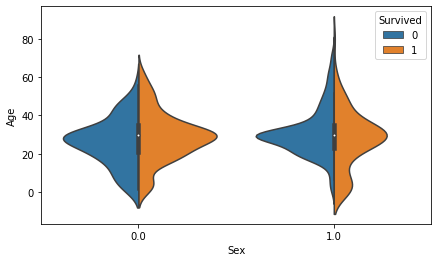

In [36]:
fig = plt.figure(figsize=(7, 4))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=transformed, 
               split=True,
              );

The second affirmation may be visualised with a stacked graph, now focusing on the percentage rather than the raw number, removing the prior probability to have a certain class.

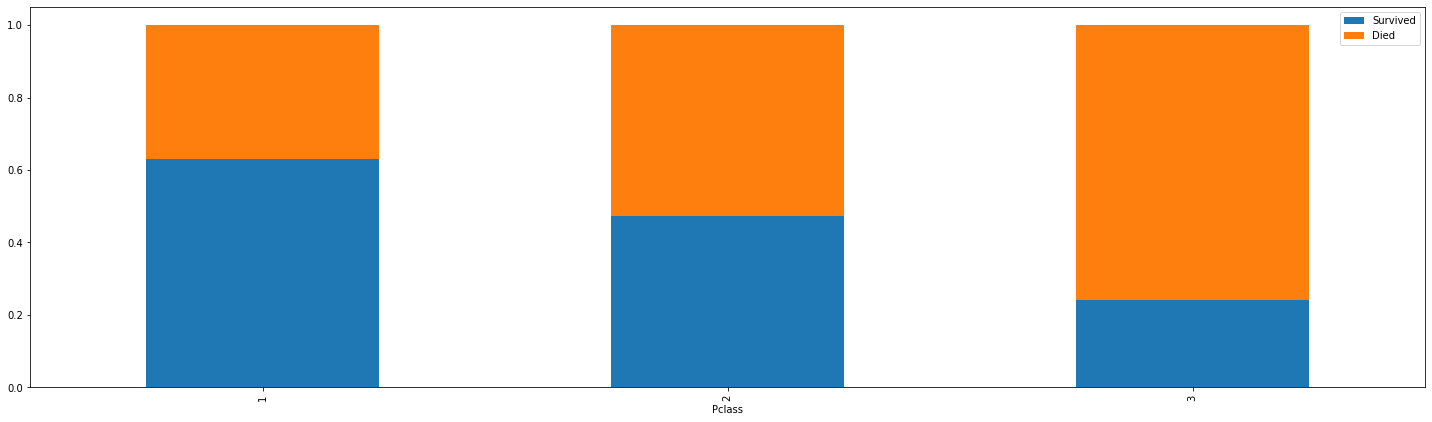

In [37]:
train_data["Died"] = 1 - train_data.Survived
train_data.groupby('Pclass').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

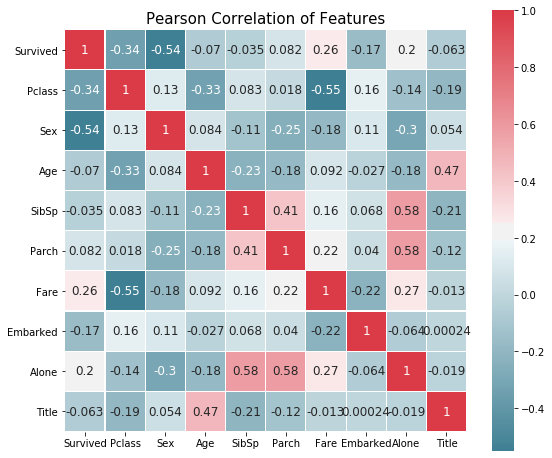

In [38]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(9, 9))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(transformed)


To further visualise the feature importance, we can fit a tree model such as xgboost, most models having built-in functions for this endeavor. For this, we will also need to use the standardized dataset. We can also compare the difference in feature importance between the two encodings.

In [39]:
def get_feature_importance(X,Y):
    xgb = XGBClassifier()
    xgb.fit(X,Y)
    importances = pd.Series(xgb.feature_importances_, index = X.columns)
    return importances
standardized_ordinal = pd.read_csv(processed_data_folder + "standardized_train_ordinal.csv")
standardized_onehot = pd.read_csv(processed_data_folder + "standardized_train_onehot.csv")

In [40]:
ordinal_split = split_train(standardized_ordinal,0)
onehot_split = split_train(standardized_onehot,0)

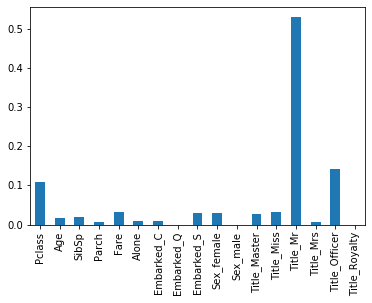

In [41]:
onehot_importances = get_feature_importance(onehot_split[0],onehot_split[2])
onehot_importances.plot(kind = 'bar')

In [42]:
ordinal_importances = get_feature_importance(ordinal_split[0],onehot_split[2])

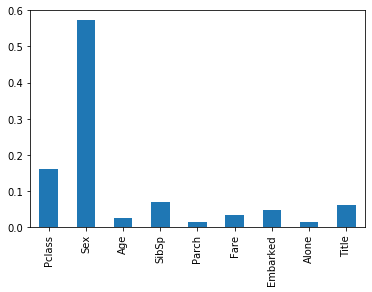

In [43]:
ordinal_importances.plot(kind="bar")

From this visualization we can conclude that while sex is certainly the most important deciding factor by a long shot(expressed by Sex in the ordinal encoding and the "Mr" title in the onehot), the two encoding tend to give very large differences in feature importance. Because of this, we should train the models separately for these 2 cases and see which tends to do better on a validation set to decide what is our prime model/models and their corresponding encoding

# 3. Exploratory analysis

For PCA to work, we will need to fully process the dataset, then standardize it to have mean 0 and standard deviation 1.
<br>
Then, we can visualize the difference between the two encodings and try to observe if one gives far better separation than the other

In [44]:
# %matplotlib notebook
# if we run this part separately and use the magic command above, we get 3D movable graphics

In [45]:
data_ordinal = pd.read_csv(processed_data_folder + "standardized_train_ordinal.csv")
data_onehot = pd.read_csv(processed_data_folder + "standardized_train_onehot.csv")

target = data_ordinal.Survived

data_ordinal.drop("Survived",axis = 1, inplace = True)
data_onehot.drop("Survived",axis = 1, inplace = True)

(891, 3)


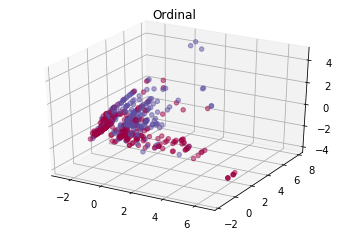

In [46]:
pca = PCA(n_components = 3)
projected = pca.fit_transform(data_ordinal)

ax = plt.axes(projection = '3d')
print(projected.shape)
ax.set_title("Ordinal")
ax.scatter3D(projected[:, 0], projected[:, 1],projected[:,2],
            c=target, alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

In [47]:
# principal_components = pca.fit(data).components_

In [48]:
# pd.DataFrame(principal_components,columns = data.columns)

(891, 3)


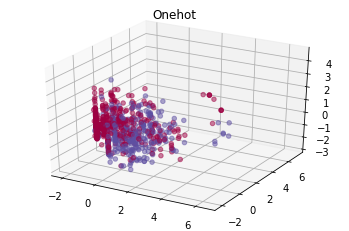

In [49]:
pca = PCA(n_components = 3)
projected = pca.fit_transform(data_onehot)

ax = plt.axes(projection = '3d')
print(projected.shape)
ax.set_title("Onehot")
ax.scatter3D(projected[:, 0], projected[:, 1],projected[:,2],
            c=target, alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

As we can see, onehot encoding seems to separate the data better. However, the difference is not big enough to completely exclude the ordinal encoding due to the variation the latter may bring when in its original 11-dimensional space.
We can conclude both are worth trying out.

# 4. Modelling

In [50]:
standardized_train_onehot = pd.read_csv(processed_data_folder + "standardized_train_onehot.csv")
standardized_test_onehot = pd.read_csv(processed_data_folder + "standardized_train_onehot.csv")

standardized_train_ordinal = pd.read_csv(processed_data_folder + "standardized_train_ordinal.csv")
standardized_test_ordinal = pd.read_csv(processed_data_folder + "standardized_train_ordinal.csv")

# Workflow
Since we have data that is mostly categorical, we can draw some conclusions:
1. A neural network/perceptron/logistic regression probably will not perform well
2. We dont have text data so a weighted Bayes is not preferred

A good aspect of this dataset is it's medium sized, meaning:
1. We can brute force(Grid Search) a lot of algortihms to see what si best, then refine the search for some
2. We can make try both encodings, and see if the best performing algorithms prefer one or the other.
<br>
We will first make use of just the F1 score for quick and dirty filtering of algorithms. Given one single metric, we can quicly eliminate the low performers. 
<br>
After we eliminate the low performers, we can compare the metrics on the better ones and even retrain using finer Grid Search.

We will make functions out of each model training, so they can be adapted to different data preprocessings and be iterated upon.
<br>
All the models have a default grid, but can be fed different search grids as a function parameter.

#### Helper functions:
Below we have some wrappers around the scikit API to modularize the code and get rid of repetitions

In [51]:
def randomized_search_model(X,Y,model, grid, n_iter,n_jobs = 6):
    """Perform randomized parameter search on the model according to the grid.
    This function requires the full dataset because it makes use of cross-validation"""
    rs_classif = RandomizedSearchCV(estimator = model, param_distributions= grid,
                                    n_iter = n_iter, cv = 5, verbose = 1,n_jobs = n_jobs)
    rs_classif.fit(X,Y)
    return rs_classif

def grid_search_model(X,Y,model, grid,n_jobs = 6):
    gs_classif = GridSearchCV(estimator = model, param_grid = grid,
                              cv =5, verbose = 1, n_jobs = n_jobs)
    gs_classif.fit(X,Y)
    return gs_classif

def eval_on_test(model,X,Y,method = f1_score):
    Y_pred = model.predict(X)
    value = method(Y,Y_pred)
    print(value)
    return value

def full_metrics(model,x,y):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.
    """
    y_true = y
    y_pred = model.predict(x)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    metric_dict = {"accuracy": round(accuracy, 4),
                   "precision": round(precision, 4), 
                   "recall": round(recall, 4),
                   "f1": round(f1, 4)}
    print(f"Acc: {accuracy * 100:.4f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")

    return metric_dict
def plot_conf_mat(conf_mat):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(conf_mat,
                     annot=True, # Annotate the boxes 
                     cbar=False,
                     fmt = 'g')

    plt.xlabel('true label')
    plt.ylabel('predicted label');

Training a random forest classifier

In [53]:
def train_rf(X_train, X_test, Y_train, Y_test, grid = None):
    if grid is None:
        grid_rf = {"n_estimators": [40,50,100],
                "max_depth": [None, 5, 10, 20],
                "max_features": ["auto", "sqrt"],
                "min_samples_split": [2, 4, 6],
                "min_samples_leaf": [1, 2, 4]}
    else:
        grid_rf = grid
#     parameter_grid = {
#                  'max_depth' : [4, 6, 8],
#                  'n_estimators': [50, 10],
#                  'max_features': ['sqrt', 'auto', 'log2'],
#                  'min_samples_split': [2, 3, 10],
#                  'min_samples_leaf': [1, 3, 10],
#                  'bootstrap': [True, False],
#                  }
    rf = grid_search_model(X_train,Y_train,RandomForestClassifier(),grid_rf)
    f1 = (eval_on_test(rf,X_train,Y_train), 
          eval_on_test(rf, X_test, Y_test))
    return rf,f1

Support Vector Classifier

In [54]:
def train_svc(X_train, X_test, Y_train, Y_test, grid = None):
    if grid is None:
        grid_svc = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [10, 100, 1000, 2000]},
                {'kernel': ['linear'], 'C': [10, 100, 1000, 2000]}]
    else:
        grid_svc = grid
    svc = randomized_search_model(X_train,Y_train,SVC(),grid_svc,20)
    f1 = (eval_on_test(svc,X_train,Y_train), 
          eval_on_test(svc, X_test, Y_test))
    return svc,f1

In [55]:
def train_knn(X_train, X_test, Y_train, Y_test, grid = None):
    if grid is None:
        grid_knn = [{'n_neighbors': [3,5,7,11], 'weights':['uniform','distance'], 'metric': ['euclidean','manhattan']}]
    else:
        grid_knn = grid
    knn = grid_search_model(X_train, Y_train, KNeighborsClassifier(),grid_knn)
    f1 = (eval_on_test(knn,X_train,Y_train), 
          eval_on_test(knn, X_test, Y_test))
    return knn,f1

In [56]:
def train_adaboost(X_train, X_test, Y_train, Y_test, grid = None):
#     grid_adaboost = {
#      'n_estimators': [50,75, 100],
#      'learning_rate' : [0.01,0.05,0.1,0.3,1],
#      'loss' : ['linear', 'square', 'exponential']
#      }
    if grid is None:
        grid_adaboost = {"base_estimator__criterion" : ["gini", "entropy"],
                         "base_estimator__splitter" :   ["best", "random"],
                         "n_estimators": [50,75,100,125]}
    else:
        grid_adaboost = grid
    # ab = AdaBoostClassifier().fit(X_train,Y_train)
    DTC = DecisionTreeClassifier(max_features = "auto",max_depth = 6)

    adaboost = grid_search_model(X_train,Y_train, AdaBoostClassifier(base_estimator= DTC), grid_adaboost)

    f1 = (eval_on_test(adaboost,X_train,Y_train), 
          eval_on_test(adaboost, X_test, Y_test))
    return adaboost,f1

In [57]:
# def train_gp(X_train, X_test, Y_train, Y_test):
#     grid_gp = {'kernel':[RBF(1.0), 0.5* RBF(1.0), 0.33* RBF(1.0), 0.1 * RBF(1.0), RBF(0.5)],
#                  'n_restarts_optimizer' : [0,1,2,3]}
#     gp = grid_search_model(X_train, Y_train, GaussianProcessClassifier(RBF(1.0)), grid_gp, 5)

#     eval_on_test(gp,X_train,Y_train)
#     eval_on_test(gp,X_test,Y_test)
#     return gp

In [58]:
def train_xgb(X_train, X_test, Y_train, Y_test, grid = None, early_stopping_rounds=50):
    
    if grid is None:
        grid_xg ={
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }
    else:
        grid_xg = grid
    xgb = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1)
    
    
#     gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#      param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    
    
    
    xgb_param = xgb.get_xgb_params()
    xgtrain = DMatrix(X_train, label=Y_train)
    cvresult = cv(xgb_param, xgtrain, num_boost_round=xgb.get_params()['n_estimators'], nfold=5,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    xgb.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    xgb.fit(X_train, Y_train)

    f1 = (eval_on_test(xgb,X_train,Y_train), 
          eval_on_test(xgb, X_test, Y_test))
    return xgb,f1

In [59]:

def train_all(X_train, X_test, Y_train, Y_test):
    sep = '-'*80
    print(sep)
    print("Random Forest",flush=True)
    rf, rff1 = train_rf(X_train, X_test, Y_train, Y_test)
    print(sep)
    print("Support Vector Classifier",flush=True)
    svc, svcf1 = train_svc(X_train, X_test, Y_train, Y_test)
    print(sep)
    print("K Nearest Neighbors",flush=True)
    knn, knnf1 = train_knn(X_train, X_test, Y_train, Y_test)
    print(sep)
    print("Adaboost",flush=True)
    adaboost,adaboostf1 = train_adaboost(X_train, X_test, Y_train, Y_test)
#     print('-'*20)
#     print("Gaussian Process")
#     gp = train_gp(X_train, X_test, Y_train, Y_test)
    print(sep)
    print("XGBoost Classifier")
    xgb,xgbf1 = train_xgb(X_train, X_test, Y_train, Y_test)
    print(sep)
    print("")
    return {'rf':(rf,rff1),'svc':(svc,svcf1),'knn':(knn,knnf1),'adaboost':(adaboost,adaboostf1),'xgb':(xgb,xgbf1)}

In [60]:

onehot_split = split_train(standardized_train_onehot,.2)
models_onehot = train_all(*onehot_split)

--------------------------------------------------------------------------------
Random Forest
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   18.0s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   30.3s


0.8410852713178294
0.7154471544715448
--------------------------------------------------------------------------------
Support Vector Classifier


[Parallel(n_jobs=6)]: Done 1080 out of 1080 | elapsed:   40.1s finished
E:\Programe\Anaconda3\envs\rltorch\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.7916666666666665
0.6991869918699186
--------------------------------------------------------------------------------
K Nearest Neighbors


[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   33.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.8015267175572519
0.7226890756302521
--------------------------------------------------------------------------------
Adaboost


[Parallel(n_jobs=6)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    2.9s finished


0.9505703422053231
0.7154471544715448
--------------------------------------------------------------------------------
XGBoost Classifier
0.875968992248062
0.7540983606557377
--------------------------------------------------------------------------------



In [61]:
ordinal_split = split_train(standardized_train_ordinal,.2)
models_ordinal = train_all(*ordinal_split)

--------------------------------------------------------------------------------
Random Forest
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   10.6s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   24.5s


0.8941176470588236
0.7941176470588235
--------------------------------------------------------------------------------
Support Vector Classifier


[Parallel(n_jobs=6)]: Done 1080 out of 1080 | elapsed:   30.6s finished
E:\Programe\Anaconda3\envs\rltorch\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.7671232876712328
0.7887323943661971
--------------------------------------------------------------------------------
K Nearest Neighbors


[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   40.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.7976878612716762
0.7659574468085105
--------------------------------------------------------------------------------
Adaboost


[Parallel(n_jobs=6)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done  69 out of  80 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    2.8s finished


0.9407265774378585
0.7083333333333335
--------------------------------------------------------------------------------
XGBoost Classifier
0.8863198458574182
0.7611940298507464
--------------------------------------------------------------------------------



# Iterative training approach
Now that we have a raw sense of what each algorithms does with each encoding, we can move on to iterating the best.
<br>
We will choose two categories:
1. The ones that overfit the training set, because that gives us the choice to regularize and decrease variance to improve performance
2. The ones that do well out of the box,giving good performance on both the cross-validation tests and the validation set.

In [ ]:
# joblib.dump(models,"..//models//onehot_models_it1.pkl")
# joblib.dump(models_ordinal,"..//models//ordinal_models_it1.pkl")

In [ ]:
# onehot_models = joblib.load("..//models//onehot_models_it1.pkl")

In [62]:
selected_onehots = {model_name : models_onehot[model_name] for model_name in ["rf","adaboost","xgb"]}

In [65]:
for name,model in selected_onehots.items():
    print(name)
    full_metrics(model[0],onehot_split[1],onehot_split[3])
    print()

rf
Acc: 80.4469%
Precision: 0.8148
Recall: 0.6377
F1 score: 0.7154

adaboost
Acc: 80.4469%
Precision: 0.8148
Recall: 0.6377
F1 score: 0.7154

xgb
Acc: 83.2402%
Precision: 0.8679
Recall: 0.6667
F1 score: 0.7541



In [67]:
selected_ordinals = {model_name : models_ordinal[model_name] for model_name in ["rf","adaboost","xgb"]}
for name,model in selected_ordinals.items():
    print(name)
    full_metrics(model[0],ordinal_split[1],ordinal_split[3])
    print()

rf
Acc: 84.3575%
Precision: 0.8571
Recall: 0.7397
F1 score: 0.7941

adaboost
Acc: 76.5363%
Precision: 0.7183
Recall: 0.6986
F1 score: 0.7083

xgb
Acc: 82.1229%
Precision: 0.8361
Recall: 0.6986
F1 score: 0.7612



The random forest for ordinals seems to perform the best, so we will save it and make a submission with that

In [75]:
model_final = selected_ordinals["rf"][0]
joblib.dump(model_final, models_folder + "rf79_ordinal.pkl")

['models//rf79.pkl']

In [82]:
initial_test = pd.read_csv(raw_data_folder+"test.csv")
standardized_test = pd.read_csv(processed_data_folder+"standardized_test_ordinal.csv")

In [83]:
survived = model_final.predict(standardized_test)

In [84]:
submission = pd.DataFrame({"PassengerId":initial_test.PassengerId, "Survived": survived})

In [87]:
submission
submission.to_csv("submission_rf79_ordinal.csv",index=False)